In [1]:
import os
import torch
from pathlib import Path
import pandas as pd

from fastai.torch_core import set_seed

from fastai.vision.learner import Learner

from fastai.callback.fp16 import to_fp16

from fastcore.foundation import L

from utils_f.gpu import manage_gpu
from utils_f.path import get_feature_paths, get_label_paths, get_learner_paths
from utils_f.export import export_features, export_labels, save_models
from utils_f.metrics import get_all_precision_at_k
from utils_f.log import log_excel, precision_at_k_to_dataframe, dataframes_to_excel
from utils_f.model.model_custom import *
from utils_f.data.data_custom import *

# Hyperparameter

In [2]:
batch_size = 32

# Seed

In [3]:
set_seed(42, True)

# Environment

In [4]:
os.environ["TORCH_HOME"] = "Model/"
os.environ["FASTAI_HOME"] = "Data/"

# Device

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Module

In [6]:
def get_features(dts_li, model_li, with_labels= False):

    learners = [Learner(dts.dls, model).to_fp16() for dts in dts_li for model in model_li]
    
    preds_data_li = [(lrnr.get_preds(0), manage_gpu())[0] for lrnr in learners] 
    preds_trgt_li = [(lrnr.get_preds(1), manage_gpu())[0] for lrnr in learners]

    fts_data_li = [preds[0] for preds in preds_data_li]
    fts_trgt_li = [preds[0] for preds in preds_trgt_li]
    result = [fts_data_li, fts_trgt_li]

    if with_labels:

        lbls_data_li = [preds[1] for preds in preds_data_li]
        lbls_trgt_li = [preds[1] for preds in preds_trgt_li]
        result.append(lbls_data_li)
        result.append(lbls_trgt_li)
    
    return tuple(result)


def get_distances(fts_trgt_li, fts_data_li, output_dtype= torch.float16):

    return [torch.cdist(fts_trgt, fts_data, p= 2).type(output_dtype)
            for fts_trgt, fts_data in zip(fts_trgt_li, fts_data_li)]


def sort_indexes(dists_li):

    return [torch.sort(dist, dim= 1)[1] for dist in dists_li]


# non-original
def run_each(dts_li, model_li):

    df_li = []

    for dts in dts_li:

        print(f"{dts.name} --------------------")

        dts = [dts]
        
        for idx, model in enumerate(model_li):
            
            print(f"{model.name} -----")
            
            model = [model]
            fts_data_li, fts_trgt_li, lbls_data_li, lbls_trgt_li = get_features(dts, model, with_labels= True)
    
            fts_data_path_li, fts_trgt_path_li = get_feature_paths(dts, model)
            export_features(fts_data_li, fts_trgt_li, fts_data_path_li, fts_trgt_path_li)
    
            lbls_data_path_li, lbls_trgt_path_li = get_label_paths(dts, model)
            export_labels(lbls_data_li, lbls_trgt_li, lbls_data_path_li, lbls_trgt_path_li)
    
            dists_li = get_distances(fts_trgt_li, fts_data_li, output_dtype= torch.float16)
            
            idxs_li = sort_indexes(dists_li)
    
            k_li = [1, 2, 3, 4, 5, 6, 7, 8]
            precision_at_k_li = get_all_precision_at_k(k_li, idxs_li, lbls_data_li, lbls_trgt_li, transpose= True)
    
            df = precision_at_k_to_dataframe(dts[0], model[0], precision_at_k_li[0], k_li, idx= idx)
            df_li.append(df)
    
            manage_gpu(verbal= False)

        print()

    save_models(model_li)

    return dataframes_to_excel(df_li)

# ----------------------------------------

# Data

[None, None, None, None, None, None, None, None, None, None]

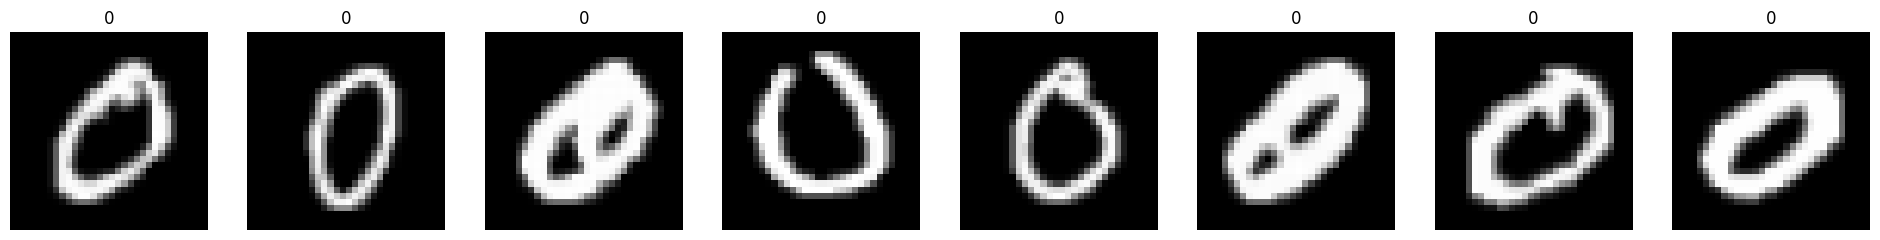

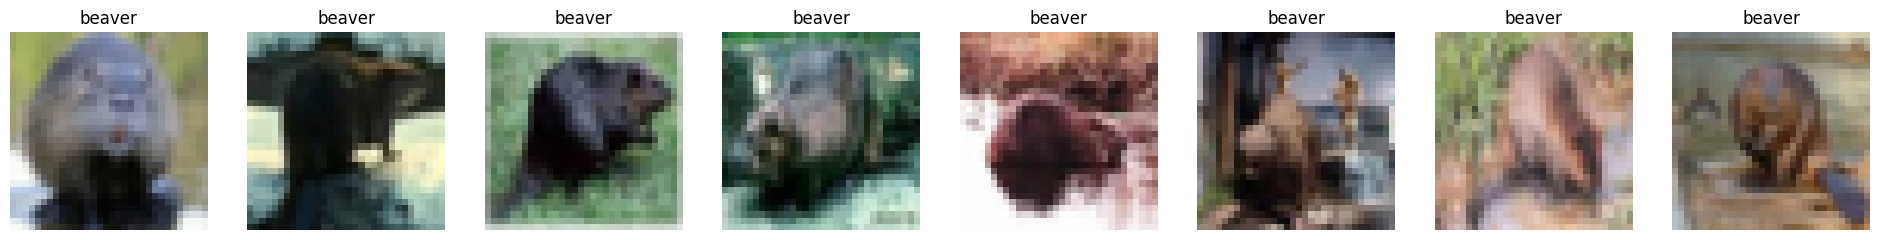

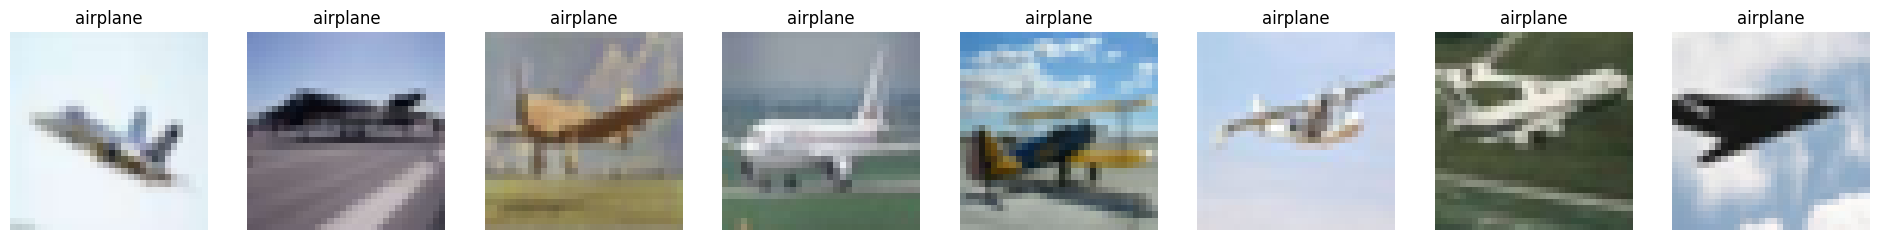

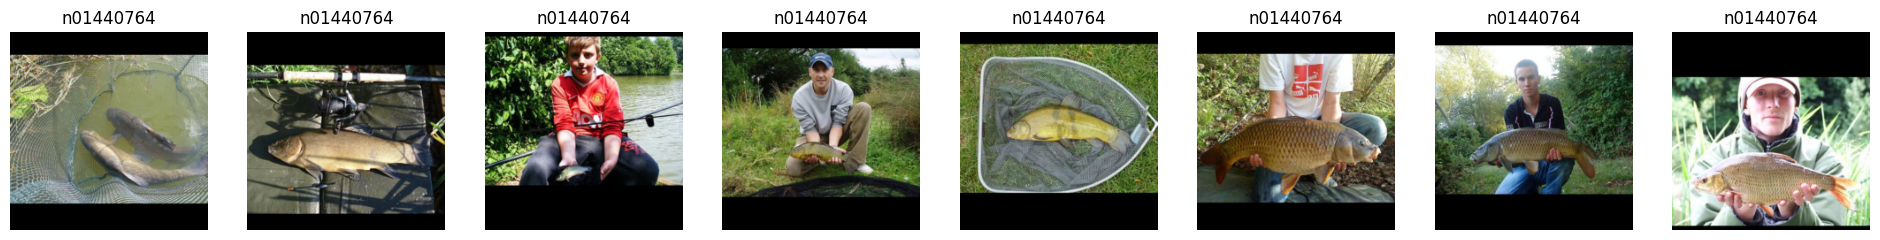

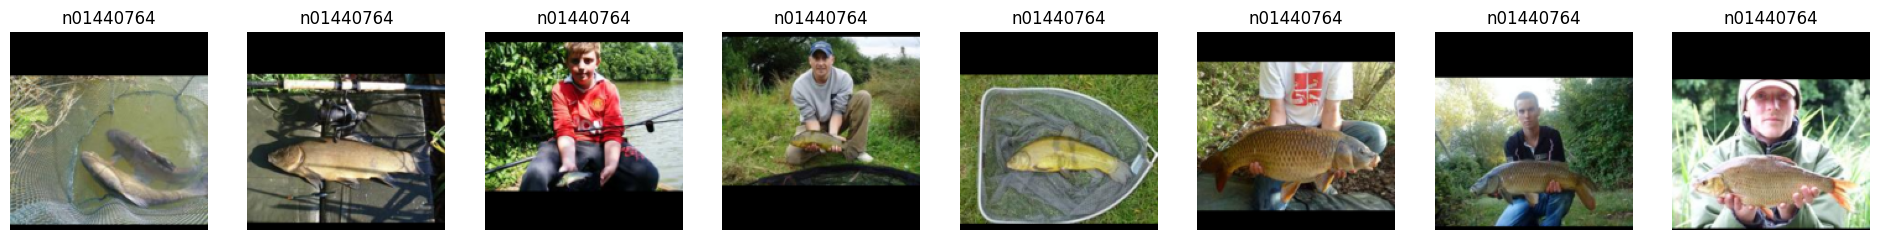

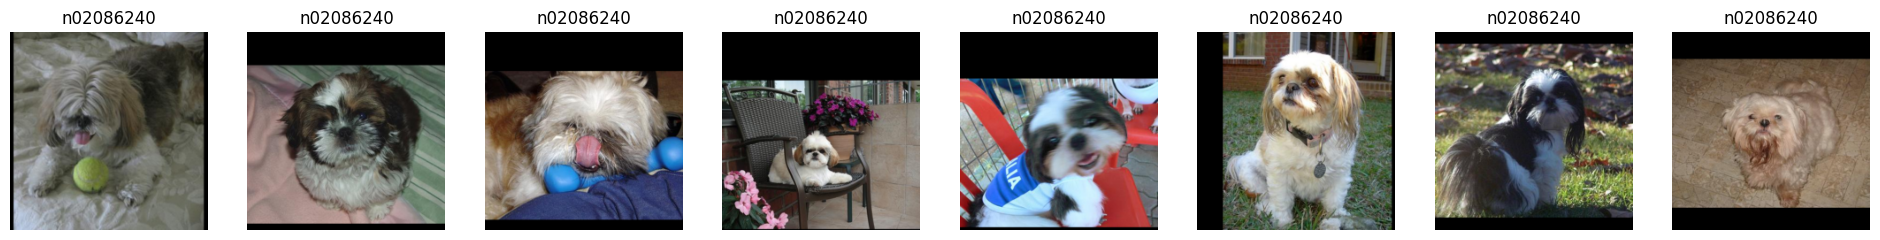

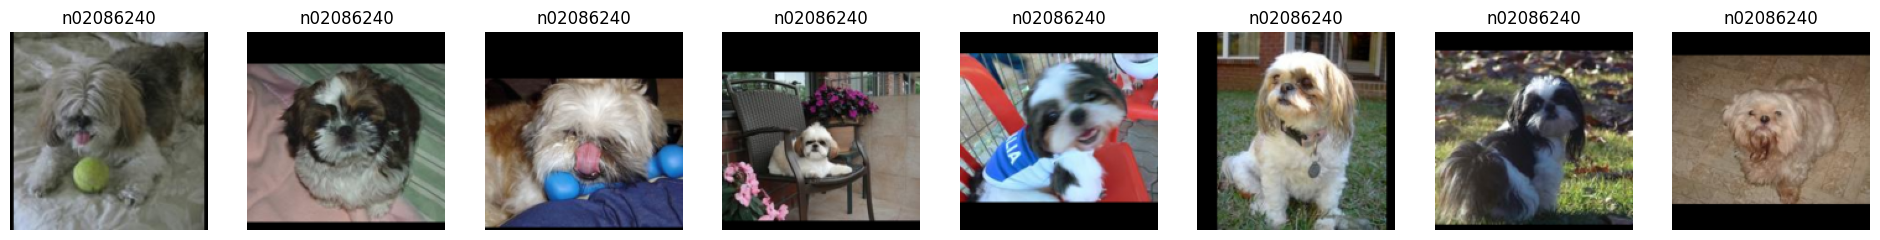

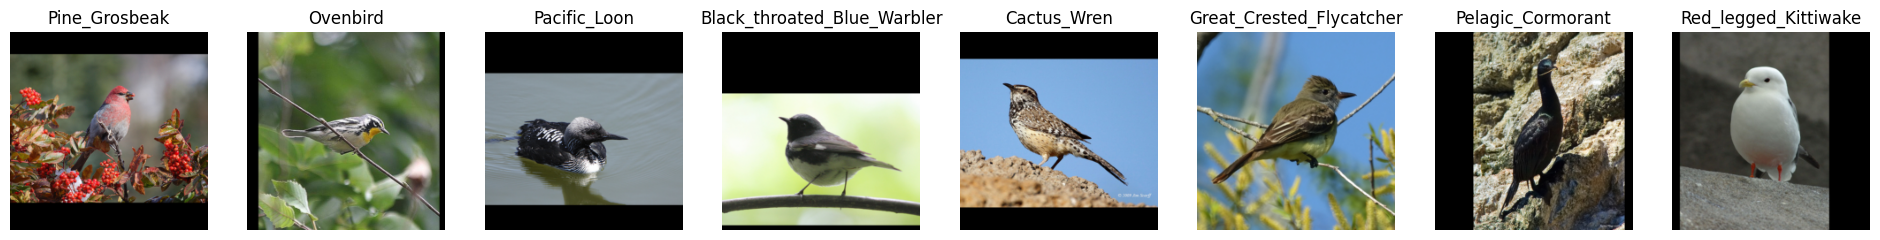

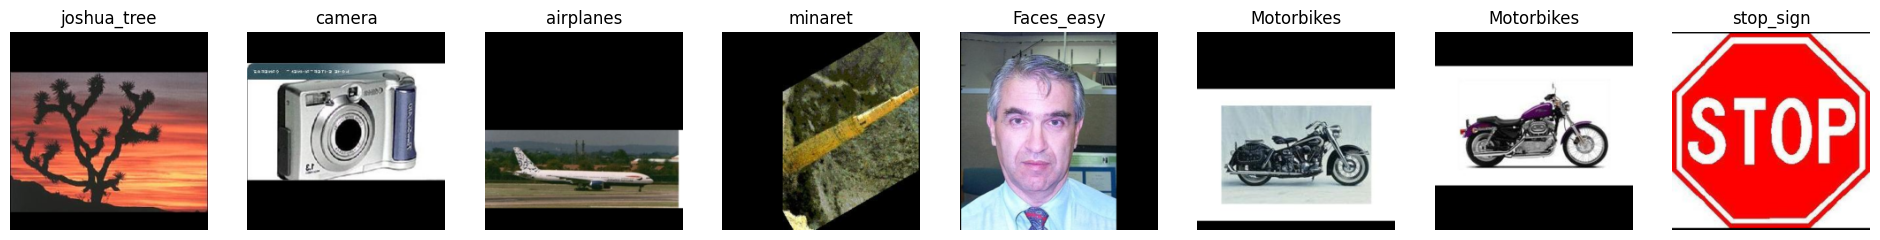

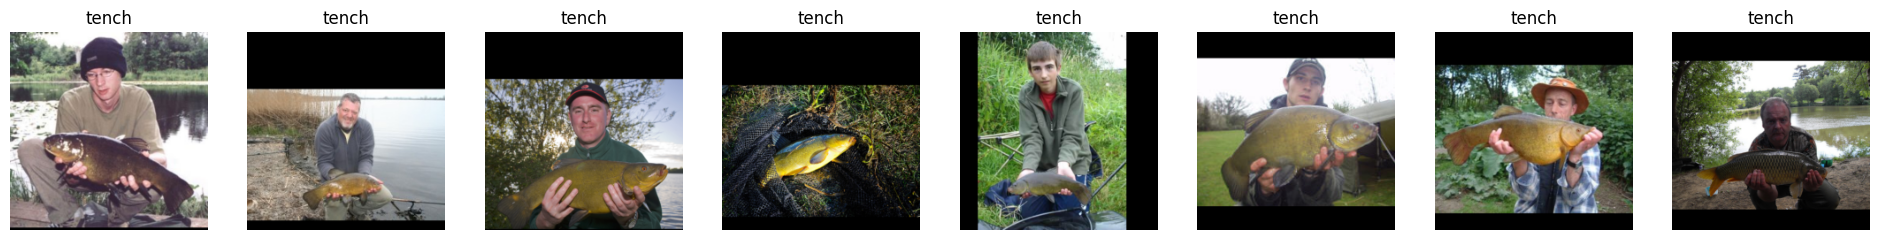

In [7]:
dts_li = [Mnist(), Cifar100(), Cifar10(), Imagenette320(), Imagenette160(), 
           Imagewoof320(), Imagewoof160(), Cub200_2011(), Caltech101(), Extract1000Fast()]

[dts.dls.train.show_batch(max_n= 8, nrows= 1) for dts in dts_li]

# ----------------------------------------

# Model

In [8]:
model_li = [ConvnextLarge(), ConvnextSmall(), Resnet152(), Efficientnetv2RwT(),
            EfficientnetB3(), Resnet26d(), Vgg16()]

[model.name for model in model_li]

['convnext_large',
 'convnext_small',
 'resnet152',
 'efficientnetv2_rw_t',
 'efficientnet_b3',
 'resnet26d',
 'vgg16']

# Save Models

In [ ]:
save_models(model_li)

# ----------------------------------------

# Run

In [ ]:
# %%time

# result = run_each(dts_li, model_li)
# result

# ----------------------------------------

# Features

In [ ]:
%%time

fts_data_li, fts_trgt_li, lbls_data_li, lbls_trgt_li = get_features(dts_li, model_li, with_labels= True)

In [ ]:
fts_data_shp = [fts.shape for fts in fts_data_li]
fts_trgt_shp = [fts.shape for fts in fts_trgt_li]

for x in L(zip(fts_data_shp, fts_trgt_shp)):
    print(x)

In [ ]:
lbls_data_shp = [lbls.shape for lbls in lbls_data_li]
lbls_trgt_shp = [lbls.shape for lbls in lbls_trgt_li]

for x in L(zip(lbls_data_shp, lbls_trgt_shp)):
    print(x)

# ----------------------------------------

# Export Features

In [ ]:
fts_data_path_li, fts_trgt_path_li = get_feature_paths(dts_li, model_li)
fts_data_path_li[:6], fts_trgt_path_li[:6]

In [ ]:
export_features(fts_data_li, fts_trgt_li, fts_data_path_li, fts_trgt_path_li)

# Export Labels

In [ ]:
lbls_data_path_li, lbls_trgt_path_li = get_label_paths(dts_li, model_li)
lbls_data_path_li[:6], lbls_trgt_path_li[:6]

In [ ]:
export_labels(lbls_data_li, lbls_trgt_li, lbls_data_path_li, lbls_trgt_path_li)

# Save Models

In [ ]:
save_models(model_li)

# ----------------------------------------

# Load Features

In [ ]:
fts_data_path_li, fts_trgt_path_li = get_feature_paths(dts_li, model_li)
fts_data_path_li[:6], fts_trgt_path_li[:6]

In [ ]:
fts_data_li = [torch.load(p) for p in fts_data_path_li]
fts_trgt_li = [torch.load(p) for p in fts_trgt_path_li]

fts_data_shp = [fts.shape for fts in fts_data_li]
fts_trgt_shp = [fts.shape for fts in fts_trgt_li]
for x in L(zip(fts_data_shp, fts_trgt_shp)):
    print(x)

# Load Labels

In [ ]:
lbls_data_path_li, lbls_trgt_path_li = get_label_paths(dts_li, model_li)
lbls_data_path_li[:6], lbls_trgt_path_li[:6]

In [ ]:
lbls_data_li = [torch.load(p) for p in lbls_data_path_li]
lbls_trgt_li = [torch.load(p) for p in lbls_trgt_path_li]

lbls_data_shp = [lbls.shape for lbls in lbls_data_li]
lbls_trgt_shp = [lbls.shape for lbls in lbls_trgt_li]
for x in L(zip(lbls_data_shp, lbls_trgt_shp)):
    print(x)

# ----------------------------------------

# Distance

In [ ]:
%%time

dists_li = get_distances(fts_trgt_li, fts_data_li)

dists_shp = [dists.shape for dists in dists_li]
dists_shp

# Sort Indexes

In [ ]:
%%time

idxs_li = sort_indexes(dists_li)

idxs_shp = [idxs.shape for idxs in idxs_li]
idxs_shp

# ----------------------------------------

# R Precision

In [ ]:
%%time

k_li = [1, 2, 3, 4, 5, 6, 7, 8]

precision_at_k_li = get_all_precision_at_k(k_li, idxs_li, lbls_data_li, lbls_trgt_li, transpose= True)
precision_at_k_li.shape

# ----------------------------------------

# Log

In [ ]:
df = log_excel(dts_li, model_li, precision_at_k_li, k_li)
df

# ----------------------------------------